# Modelling equity data with prophet

### Importing the Essential Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import boto3
from io import BytesIO

## Importing the Prophet Library for Time-Series Analysis

In [2]:
from prophet import Prophet

## Model Evaluator Function

In [3]:
## importing MAE and MSE modules from sklearn
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [58]:
## function to calculate scores
def model_evaluator(actual_values, predicted_values):
    mae = mean_absolute_error(actual_values, predicted_values)
    mse = mean_squared_error(actual_values, predicted_values)
    rmse = mean_squared_error(actual_values, predicted_values, squared=False)
    
    return {"MAE" : mae, "MSE": mse, "RMSE": rmse}

## Accessing the data from AWS S3 bucket

In [5]:
# s3 = boto3.client("s3")

# bucket_name = 's3bucketaimt'
# object_key = "stockdata (1).csv"

In [6]:
# file_obj = s3.get_object(Bucket=bucket_name, Key = object_key)
# df = pd.read_csv(file_obj["Body"])
# df.head()

In [7]:
df = pd.read_csv(r"C:\Users\i_udd\OneDrive - Lambton College\Lambton\TERM 4\CPL 5559\Weekly Deliverables\Week 2\stockdata.csv")

## Getting an overview of the data

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502 entries, 0 to 501
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       502 non-null    object 
 1   Open       502 non-null    float64
 2   High       502 non-null    float64
 3   Low        502 non-null    float64
 4   Close      502 non-null    float64
 5   Adj Close  502 non-null    float64
 6   Volume     502 non-null    int64  
 7   Company    502 non-null    object 
dtypes: float64(5), int64(1), object(2)
memory usage: 31.5+ KB


#### We notice above that the date column is stored in object form which is not helpful for analysis. Therefore, we will be changing the data field to time and date format

In [9]:
df["Date"] = pd.to_datetime(df["Date"])

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502 entries, 0 to 501
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       502 non-null    datetime64[ns]
 1   Open       502 non-null    float64       
 2   High       502 non-null    float64       
 3   Low        502 non-null    float64       
 4   Close      502 non-null    float64       
 5   Adj Close  502 non-null    float64       
 6   Volume     502 non-null    int64         
 7   Company    502 non-null    object        
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 31.5+ KB


#### As we can see above, the date field now appears in time and date format which we can use for time-series analysis

In [11]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Company
0,2021-01-04,120.315491,120.382408,117.629066,118.489487,104.750336,5417443,IBM
1,2021-01-05,119.512428,121.108986,119.130020,120.592735,106.609711,6395872,IBM
2,2021-01-06,121.319313,126.080307,121.147224,123.604210,109.271996,8322708,IBM
3,2021-01-07,124.321220,124.722755,122.619499,123.317398,109.018440,4714740,IBM
4,2021-01-08,122.915871,123.632889,121.395790,122.877632,108.629654,4891305,IBM


## Segregating the data by company

In [12]:
df["Company"].value_counts()

IBM     251
MSFT    251
Name: Company, dtype: int64

#### The above output shows that we have both IBM and Microsoft (MSFT) in the same dataframe. We need to seperate the data by company to create a model that is specific to a company. We will be doing that in the following code blocks.

In [13]:
df_IBM = df[df["Company"]=="IBM"]
df_MSFT = df[df["Company"]=="MSFT"]

## Selecting Volume field for time-series analysis

In [14]:
df_IBM_volume = df_IBM[["Date", "Volume"]]
df_MSFT_volume = df_MSFT[["Date", "Volume"]]

In [15]:
df_IBM_AdjClose = df_IBM[["Date", "Adj Close"]]
df_MSFT_AdjClose = df_MSFT[["Date", "Adj Close"]]

#### As per the prophet library we need to rename the data column to "ds" and the dependent variable to "y". We will do that in the following code blocks

In [16]:
df_IBM_volume = df_IBM_volume.rename(columns={"Date" : "ds", "Volume" : "y"})
df_MSFT_volume = df_MSFT_volume.rename(columns={"Date" : "ds", "Volume" : "y"})

df_IBM_AdjClose = df_IBM_AdjClose.rename(columns={"Date" : "ds", "Adj Close" : "y"})
df_MSFT_AdjClose = df_MSFT_AdjClose.rename(columns={"Date" : "ds", "Adj Close" : "y"})

## Splitting the dataset by date to create a train and test dataset

In [17]:
df_IBM_volume.sort_values(by="ds", ascending=True, inplace=True) # sorting the dataset by date (ds) column in ascending format 
                                                              # to ensure accurate forecasting

df_MSFT_volume.sort_values(by="ds", ascending=True, inplace=True) # same as above

df_IBM_AdjClose.sort_values(by="ds", ascending=True, inplace=True) # same as above

df_MSFT_AdjClose.sort_values(by="ds", ascending=True, inplace=True) # same as above

In [18]:
## set a split date
split_date = pd.to_datetime("2021-09-30")

In [21]:
## splitting IBM value data into train and test
IBM_volume_train = df_IBM_volume.loc[df_IBM_volume["ds"] <= split_date]
IBM_volume_test = df_IBM_volume.loc[df_IBM_volume["ds"] > split_date]

## splitting MSFT value data
MSFT_volume_train = df_MSFT_volume.loc[df_MSFT_volume["ds"] <= split_date]
MSFT_volume_test = df_MSFT_volume.loc[df_MSFT_volume["ds"] > split_date]

## splitting IBM Adj Close data
IBM_AdjClose_train = df_IBM_AdjClose.loc[df_IBM_AdjClose["ds"] <= split_date]
IBM_AdjClose_test = df_IBM_AdjClose.loc[df_IBM_AdjClose["ds"] > split_date]

## splitting MSFT Adj Close data
MSFT_AdjClose_train = df_MSFT_AdjClose.loc[df_MSFT_AdjClose["ds"] <= split_date]
MSFT_AdjClose_test = df_MSFT_AdjClose.loc[df_MSFT_AdjClose["ds"] > split_date]

## Creating a prophet model

In [22]:
model_IBM_volume = Prophet() # creating an instance of Prophet for IBM volume data
model_MSFT_volume = Prophet() # creating an instance of Prophet for MSFT volume data
model_IBM_AdjClose = Prophet() # creating an instance of Prophet for IBM Adjusted Closing Price
model_MSFT_AdjCLose = Prophet() # creating an instance of Prophet for MSFT Adjusted Closing Price

In [24]:
model_IBM_volume.fit(IBM_volume_train) # fitting the IBM Volume data in the model
model_MSFT_volume.fit(MSFT_volume_train) # fitting the MSFT Volume data in the model
model_IBM_AdjClose.fit(IBM_AdjClose_train) # fitting the IBM Adj Close data in the model
model_MSFT_AdjCLose.fit(MSFT_AdjClose_train) # fitting the MSFT Adj Close data in the model

14:19:16 - cmdstanpy - INFO - Chain [1] start processing
14:19:16 - cmdstanpy - INFO - Chain [1] done processing
14:19:16 - cmdstanpy - INFO - Chain [1] start processing
14:19:16 - cmdstanpy - INFO - Chain [1] done processing
14:19:16 - cmdstanpy - INFO - Chain [1] start processing
14:19:16 - cmdstanpy - INFO - Chain [1] done processing
14:19:16 - cmdstanpy - INFO - Chain [1] start processing
14:19:16 - cmdstanpy - INFO - Chain [1] done processing


## Creating future dataframes

In [26]:
future_dates_IBM_volume = model_IBM_volume.make_future_dataframe(periods=len(IBM_volume_test))
future_dates_MSFT_volume = model_MSFT_volume.make_future_dataframe(periods = len(MSFT_volume_test))

future_dates_IBM_AdjClose = model_IBM_AdjClose.make_future_dataframe(periods=len(IBM_AdjClose_test))
future_dates_MSFT_AdjClose = model_MSFT_AdjCLose.make_future_dataframe(periods=len(MSFT_AdjClose_test))

## Creating forecast value

In [27]:
forecast_IBM_volume = model_IBM_volume.predict(future_dates_IBM_volume)
forecast_MSFT_volume = model_MSFT_volume.predict(future_dates_MSFT_volume)
forecast_IBM_AdjClose = model_IBM_AdjClose.predict(future_dates_IBM_AdjClose)
forecast_MSFT_AdjClose = model_MSFT_AdjCLose.predict(future_dates_MSFT_AdjClose)

## Visualizing the predicted forecasts against Actual Values

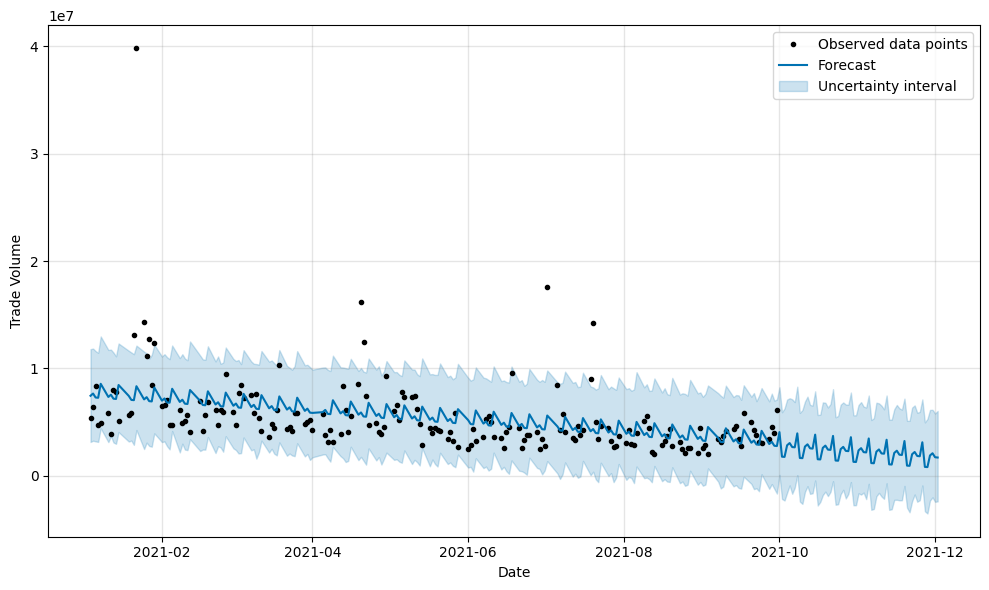

In [71]:
model_IBM_volume.plot(forecast_IBM_volume,
                     uncertainty=True, 
                     plot_cap=True,
                     xlabel="Date",
                     ylabel="Trade Volume",
                     include_legend=True);

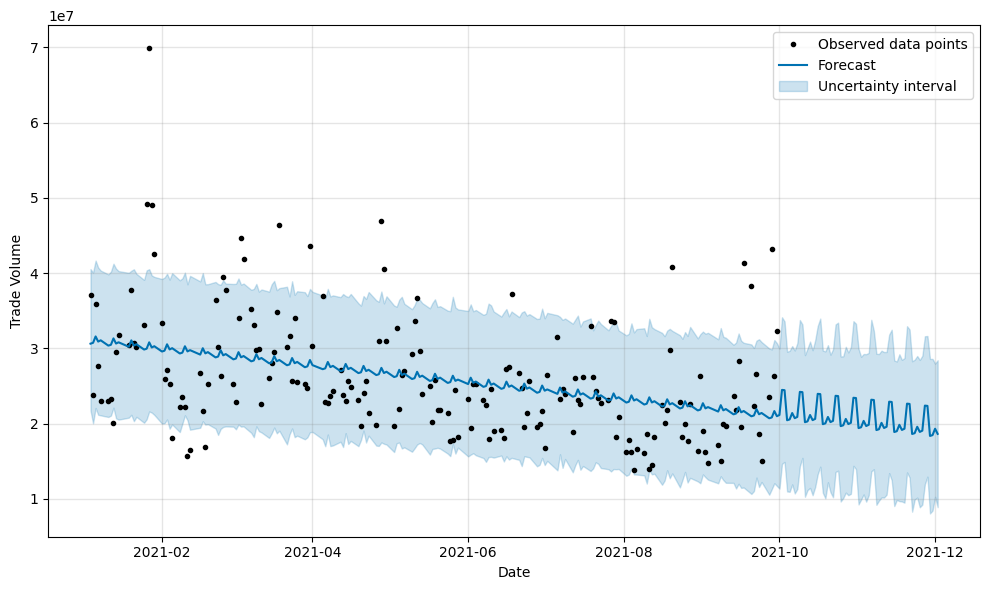

In [29]:
model_MSFT_volume.plot(forecast_MSFT_volume, 
                      uncertainty=True, 
                     plot_cap=True,
                     xlabel="Date",
                     ylabel="Trade Volume",
                     include_legend=True);

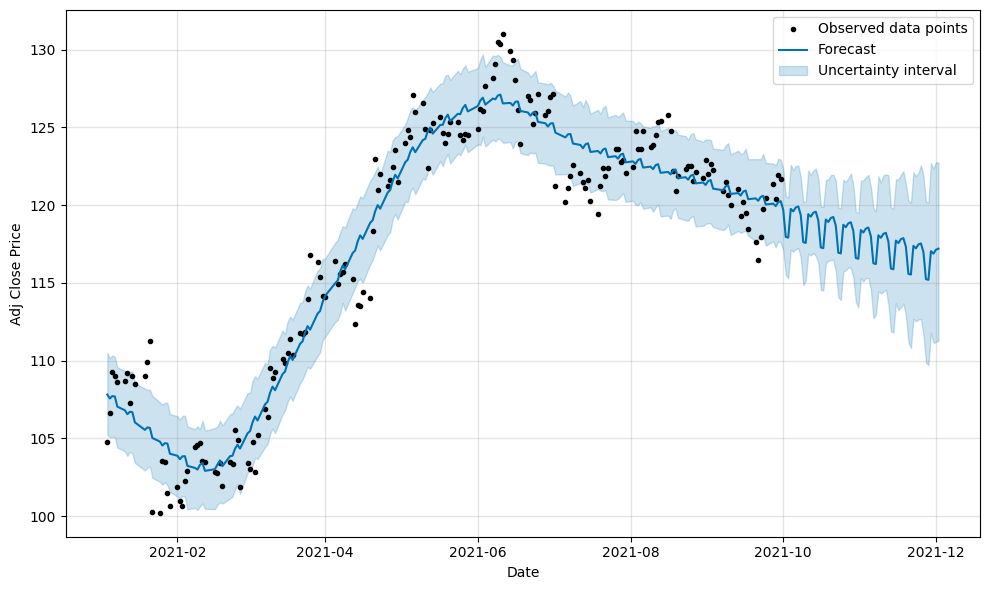

In [30]:
model_IBM_AdjClose.plot(forecast_IBM_AdjClose, 
                    uncertainty=True, 
                    plot_cap=True,
                    xlabel="Date",
                    ylabel="Adj Close Price",
                    include_legend=True);

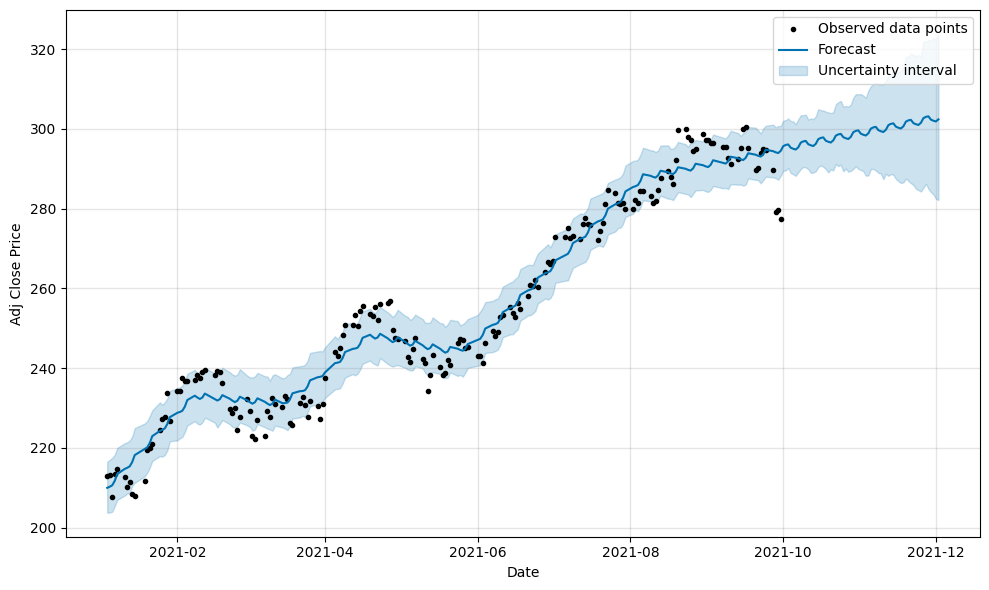

In [31]:
model_MSFT_AdjCLose.plot(forecast_MSFT_AdjClose, 
                    uncertainty=True, 
                    plot_cap=True,
                    xlabel="Date",
                    ylabel="Adj Close Price",
                    include_legend=True);

## Visualizing the Forecast Vs Actual

In [32]:
predicted_IBM_volume = forecast_IBM_volume.loc[forecast_IBM_volume["ds"] > split_date]["yhat"]
predicted_MSFT_volume = forecast_MSFT_volume.loc[forecast_MSFT_volume["ds"] > split_date]["yhat"]
predicted_IBM_AdjClose = forecast_IBM_AdjClose.loc[forecast_IBM_AdjClose["ds"] > split_date]["yhat"]
predicted_MSFT_AdjClose = forecast_MSFT_AdjClose.loc[forecast_IBM_AdjClose["ds"] > split_date]["yhat"]

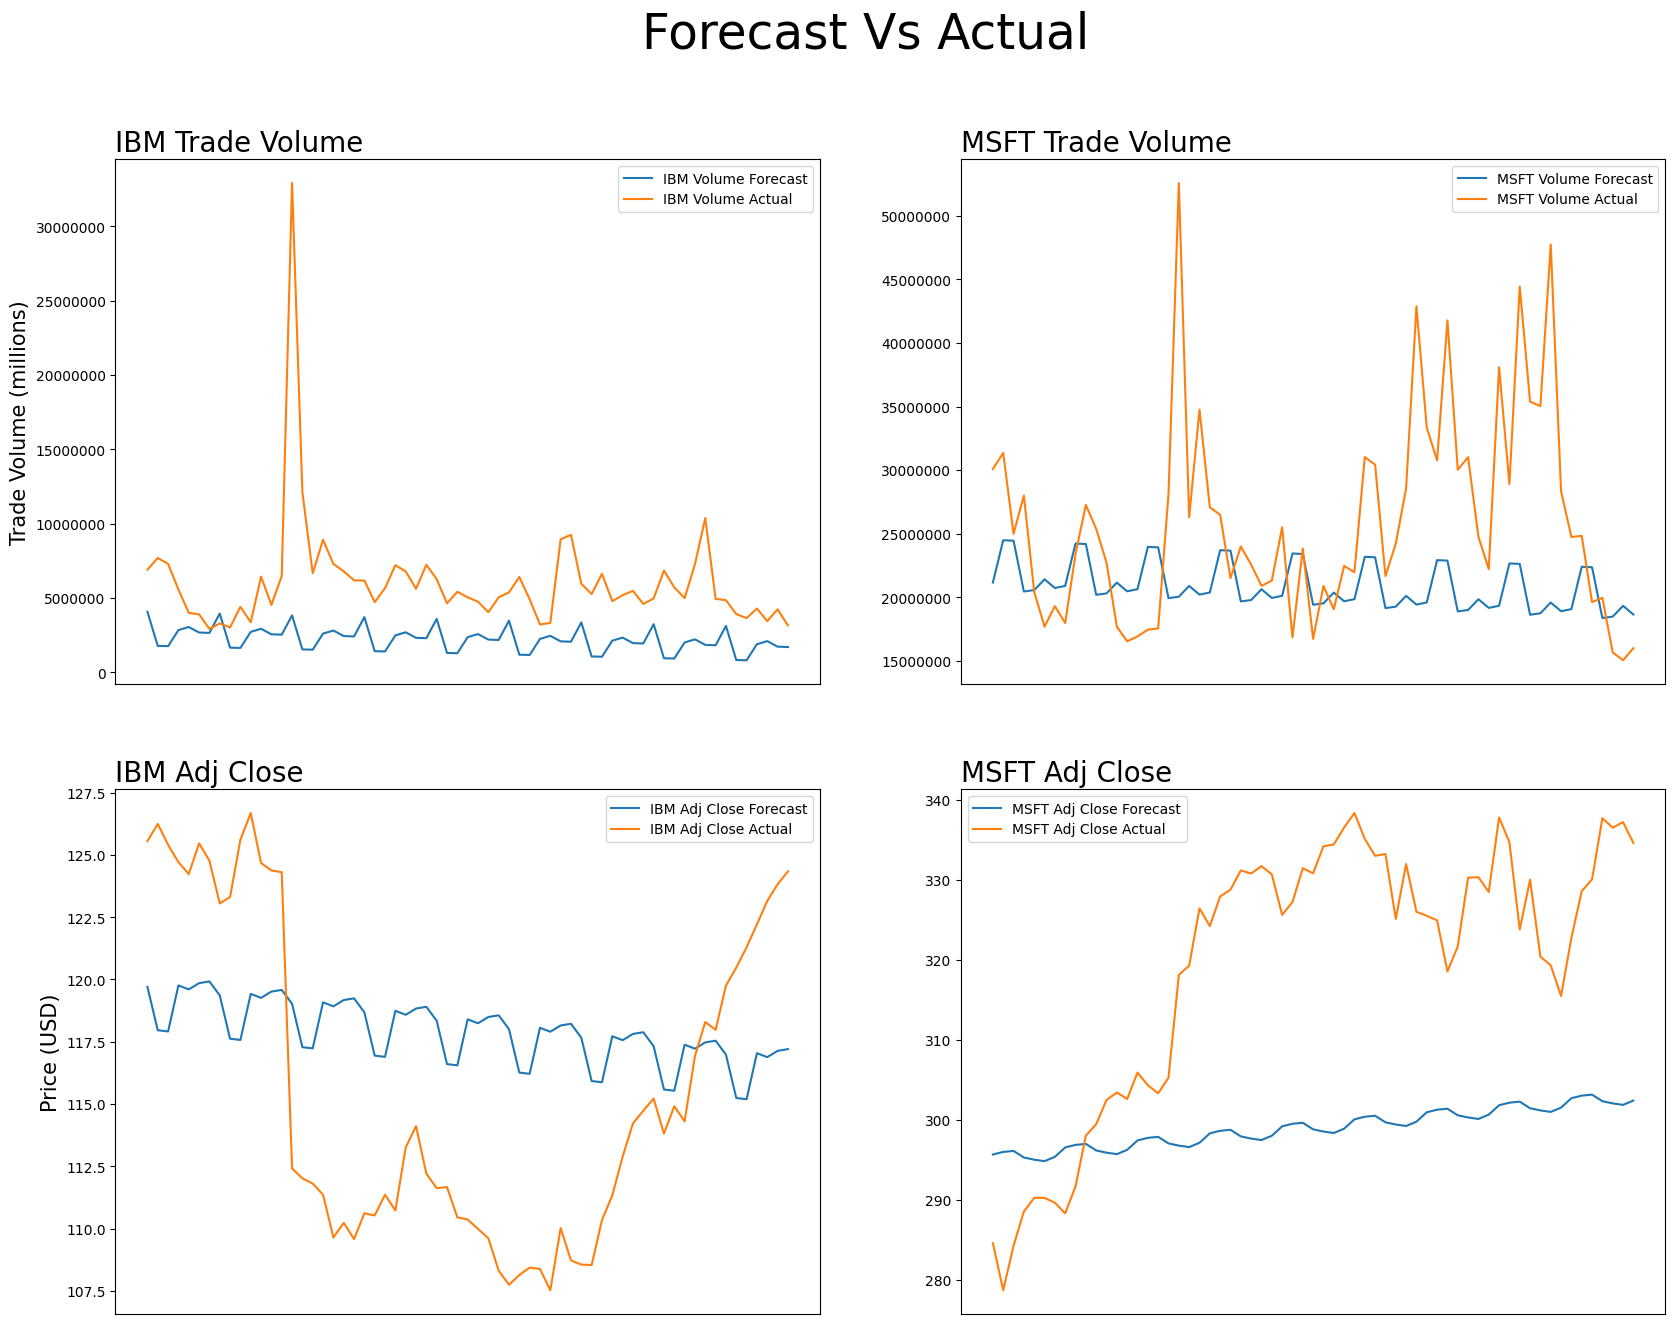

In [92]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))



fig.suptitle("Forecast Vs Actual", fontsize=35)

ax[0, 0].plot(predicted_IBM_volume, label="IBM Volume Forecast")
ax[0, 0].plot(IBM_volume_test["y"], label="IBM Volume Actual")
ax[0, 0].set_title("IBM Trade Volume", fontsize=20, loc="left")
ax[0, 0].legend()
ax[0, 0].set_ylabel("Trade Volume (millions)", fontsize=15)
ax[0, 0].ticklabel_format(style="plain")
ax[0, 0].get_xaxis().set_visible(False)

ax[0, 1].plot(predicted_MSFT_volume, label="MSFT Volume Forecast")
ax[0, 1].plot(MSFT_volume_test[["y"]].set_index(predicted_IBM_volume.index), label="MSFT Volume Actual")
ax[0, 1].set_title("MSFT Trade Volume", fontsize=20, loc="left")
ax[0, 1].legend()
ax[0, 1].ticklabel_format(style="plain")
ax[0, 1].get_xaxis().set_visible(False)



ax[1, 0].plot(predicted_IBM_AdjClose, label="IBM Adj Close Forecast")
ax[1, 0].plot(IBM_AdjClose_test["y"], label="IBM Adj Close Actual")
ax[1, 0].set_title("IBM Adj Close", fontsize=20, loc="left")
ax[1, 0].legend()
ax[1, 0].set_ylabel("Price (USD)", fontsize=15)
ax[1, 0].ticklabel_format(style="plain")
ax[1, 0].get_xaxis().set_visible(False)


ax[1, 1].plot(predicted_MSFT_AdjClose, label="MSFT Adj Close Forecast")
ax[1, 1].plot(MSFT_AdjClose_test[["y"]].set_index(predicted_MSFT_AdjClose.index), label="MSFT Adj Close Actual")
ax[1, 1].set_title("MSFT Adj Close", fontsize=20, loc="left")
ax[1, 1].legend()
ax[1, 1].ticklabel_format(style="plain")
ax[1, 1].get_xaxis().set_visible(False)

plt.show()

## Model Evaluation

In [65]:
## IBM Volume
model_evaluator(IBM_volume_test["y"], predicted_IBM_volume)

{'MAE': 3858517.9168262733, 'MSE': 28900124901990.94, 'RMSE': 5375883.63917886}

In [66]:
## MSFT Volume
model_evaluator(MSFT_volume_test["y"], predicted_MSFT_volume)

{'MAE': 6938760.044615213, 'MSE': 94906121106145.8, 'RMSE': 9741977.268816931}

In [67]:
## IBM Adj Close
model_evaluator(IBM_AdjClose_test["y"], predicted_IBM_AdjClose)

{'MAE': 6.097204860386336, 'MSE': 43.338103145743034, 'RMSE': 6.58316816933481}

In [69]:
## MSFT Adj Close
model_evaluator(MSFT_AdjClose_test["y"], predicted_MSFT_AdjClose)

{'MAE': 22.650857043491538,
 'MSE': 637.5323371335269,
 'RMSE': 25.249402708450884}